# Machine Learning with vaex.ml

If you want to try out this notebook with a live Python kernel, use mybinder:

<a class="reference external image-reference" href="https://mybinder.org/v2/gh/vaexio/vaex/latest?filepath=docs%2Fsource%2Ftutorial_ml.ipynb"><img alt="https://mybinder.org/badge_logo.svg" src="https://mybinder.org/badge_logo.svg" width="150px"></a>


The `vaex.ml` package brings some machine learning algorithms to `vaex`. If you installed the individual subpackages (`vaex-core`, `vaex-hdf5`, ...) instead of the `vaex` metapackage, you may need to install it by running `pip install vaex-ml`, or `conda install -c conda-forge vaex-ml`.

The API of `vaex.ml` stays close to that of [scikit-learn](https://scikit-learn.org/stable/), while providing better performance and the ability to efficiently perform operations on data that is larger than the available RAM. This page is an overview and a brief introduction to the capabilities offered by `vaex.ml`.

In [1]:
import vaex
vaex.multithreading.thread_count_default = 8
import vaex.ml

import numpy as np
import pylab as plt

We will use the well known [Iris flower](https://en.wikipedia.org/wiki/Iris_flower_data_set) and Titanic passenger list datasets, two classical datasets for machine learning demonstrations.

In [2]:
df = vaex.ml.datasets.load_iris()
df

#,sepal_length,sepal_width,petal_length,petal_width,class_
0,5.9,3.0,4.2,1.5,1
1,6.1,3.0,4.6,1.4,1
2,6.6,2.9,4.6,1.3,1
3,6.7,3.3,5.7,2.1,2
4,5.5,4.2,1.4,0.2,0
...,...,...,...,...,...
145,5.2,3.4,1.4,0.2,0
146,5.1,3.8,1.6,0.2,0
147,5.8,2.6,4.0,1.2,1
148,5.7,3.8,1.7,0.3,0


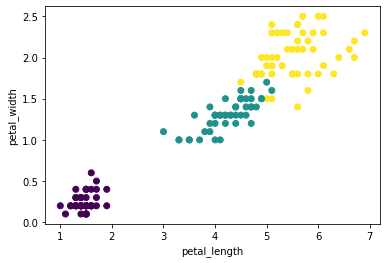

In [3]:
df.scatter(df.petal_length, df.petal_width, c_expr=df.class_);

## Preprocessing 

### Scaling of numerical features

`vaex.ml` packs the common numerical scalers:

* `vaex.ml.StandardScaler` - Scale features by removing their mean and dividing by their variance;
* `vaex.ml.MinMaxScaler` - Scale features to a given range;
* `vaex.ml.RobustScaler` - Scale features by removing their median and scaling them according to a given percentile range;
* `vaex.ml.MaxAbsScaler` - Scale features by their maximum absolute value.
 
The usage is quite similar to that of `scikit-learn`, in the sense that each transformer implements the `.fit` and `.transform` methods.

In [4]:
features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
scaler = vaex.ml.StandardScaler(features=features, prefix='scaled_')
scaler.fit(df)
df_trans = scaler.transform(df)
df_trans

#,sepal_length,sepal_width,petal_length,petal_width,class_,scaled_petal_length,scaled_petal_width,scaled_sepal_length,scaled_sepal_width
0,5.9,3.0,4.2,1.5,1,0.25096730693923325,0.39617188299171285,0.06866179325140277,-0.12495760117130607
1,6.1,3.0,4.6,1.4,1,0.4784301228962429,0.26469891297233916,0.3109975341387059,-0.12495760117130607
2,6.6,2.9,4.6,1.3,1,0.4784301228962429,0.13322594295296575,0.9168368863569659,-0.3563605663033572
3,6.7,3.3,5.7,2.1,2,1.1039528667780207,1.1850097031079545,1.0380047568006185,0.5692512942248463
4,5.5,4.2,1.4,0.2,0,-1.341272404759837,-1.3129767272601438,-0.4160096885232057,2.6518779804133055
...,...,...,...,...,...,...,...,...,...
145,5.2,3.4,1.4,0.2,0,-1.341272404759837,-1.3129767272601438,-0.7795132998541615,0.8006542593568975
146,5.1,3.8,1.6,0.2,0,-1.2275409967813318,-1.3129767272601438,-0.9006811702978141,1.726266119885101
147,5.8,2.6,4.0,1.2,1,0.13723589896072813,0.0017529729335920385,-0.052506077192249874,-1.0505694616995096
148,5.7,3.8,1.7,0.3,0,-1.1706752927920796,-1.18150375724077,-0.17367394763590144,1.726266119885101


The output of the `.transform` method of any `vaex.ml` transformer is a _shallow copy_ of a DataFrame that contains the resulting features of the transformations in addition to the original columns. A shallow copy means that this new DataFrame just references the original one, and no extra memory is used. In addition, the resulting features, in this case the scaled numerical features are _virtual columns,_ which do not take any memory but are computed on the fly when needed. This approach is ideal for working with very large datasets.

### Encoding of categorical features

`vaex.ml` contains several categorical encoders:

* `vaex.ml.LabelEncoder` - Encoding features with as many integers as categories, startinfg from 0;
* `vaex.ml.OneHotEncoder` - Encoding features according to the one-hot scheme;
* `vaex.ml.FrequencyEncoder` - Encode features by the frequency of their respective categories;
* `vaex.ml.BayesianTargetEncoder` - Encode categories with the mean of their target value;
* `vaex.ml.WeightOfEvidenceEncoder` - Encode categories their weight of evidence value.
 
 The following is a quick example using the Titanic dataset.

In [5]:
df =  vaex.ml.datasets.load_titanic()
df.head(5)

#,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
0,1,True,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.338,B5,S,2,nan,"St Louis, MO"
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,nan,"Montreal, PQ / Chesterville, ON"
2,1,False,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,None,nan,"Montreal, PQ / Chesterville, ON"
3,1,False,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,None,135,"Montreal, PQ / Chesterville, ON"
4,1,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,None,nan,"Montreal, PQ / Chesterville, ON"


In [6]:
label_encoder = vaex.ml.LabelEncoder(features=['embarked'])
one_hot_encoder = vaex.ml.OneHotEncoder(features=['embarked'])
freq_encoder = vaex.ml.FrequencyEncoder(features=['embarked'])
bayes_encoder = vaex.ml.BayesianTargetEncoder(features=['embarked'], target='survived')
woe_encoder = vaex.ml.WeightOfEvidenceEncoder(features=['embarked'], target='survived')

df = label_encoder.fit_transform(df)
df = one_hot_encoder.fit_transform(df)
df = freq_encoder.fit_transform(df)
df = bayes_encoder.fit_transform(df)
df = woe_encoder.fit_transform(df)

df.head(5)

#,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest,label_encoded_embarked,embarked_0.0,embarked_C,embarked_Q,embarked_S,frequency_encoded_embarked,mean_encoded_embarked,woe_encoded_embarked
0,1,True,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.338,B5,S,2,nan,"St Louis, MO",1,0,0,0,1,0.698243,0.337472,-0.696431
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431
2,1,False,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,None,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431
3,1,False,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,None,135,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431
4,1,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,None,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431


Notice that the transformed features are all included in the resulting DataFrame and are appropriately named. This is excellent for the construction of various diagnostic plots, and engineering of more complex features. The fact that the resulting (encoded) features take no memory, allows one to try out or combine a variety of preprocessing steps without spending any extra memory. 

## Feature Engineering

### KBinsDiscretizer

With the `KBinsDiscretizer` you can convert a continous into a discrete feature by binning the data into specified intervals. You can specify the number of bins, the strategy on how to determine their size:

* "uniform" - all bins have equal sizes;
* "quantile" - all bins have (approximately) the same number of samples in them;
* "kmeans" - values in each bin belong to the same 1D cluster as determined by the `KMeans` algorithm.

In [7]:
kbdisc = vaex.ml.KBinsDiscretizer(features=['age'], n_bins=5, strategy='quantile')
df = kbdisc.fit_transform(df)
df.head(5)

#,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest,label_encoded_embarked,embarked_0.0,embarked_C,embarked_Q,embarked_S,frequency_encoded_embarked,mean_encoded_embarked,woe_encoded_embarked,binned_age
0,1,True,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.338,B5,S,2,nan,"St Louis, MO",1,0,0,0,1,0.698243,0.337472,-0.696431,2
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431,0
2,1,False,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,None,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431,0
3,1,False,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,None,135,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431,2
4,1,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,None,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431,2


### GroupBy Transformer

The `GroupByTransformer` is a handy feature in `vaex-ml` that lets you perform a groupby aggregations on the training data, and then use those aggregations as features in the training and test sets.

In [8]:
gbt = vaex.ml.GroupByTransformer(by='pclass', agg={'age': ['mean', 'std'],
                                                   'fare': ['mean', 'std'],
                                                  })
df = gbt.fit_transform(df)
df.head(5)

#,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest,label_encoded_embarked,embarked_0.0,embarked_C,embarked_Q,embarked_S,frequency_encoded_embarked,mean_encoded_embarked,woe_encoded_embarked,binned_age,age_mean,age_std,fare_mean,fare_std
0,1,True,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.338,B5,S,2,nan,"St Louis, MO",1,0,0,0,1,0.698243,0.337472,-0.696431,2,39.1599,14.5224,87.509,80.3226
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431,0,39.1599,14.5224,87.509,80.3226
2,1,False,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,None,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431,0,39.1599,14.5224,87.509,80.3226
3,1,False,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,None,135,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431,2,39.1599,14.5224,87.509,80.3226
4,1,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,None,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431,2,39.1599,14.5224,87.509,80.3226


## Dimensionality reduction 

### Principal Component Analysis

The [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) implemented in `vaex.ml` can scale to a very large number of samples, even if that data we want to transform does not fit into RAM. To demonstrate this, let us do a PCA transformation on the Iris dataset. For this example, we have replicated this dataset thousands of times, such that it contains over **1 billion** samples.

In [9]:
df = vaex.ml.datasets.load_iris_1e9()
n_samples = len(df)
print(f'Number of samples in DataFrame: {n_samples:,}')

Number of samples in DataFrame: 1,005,000,000


In [10]:
features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
pca = vaex.ml.PCA(features=features, n_components=4, progress=True)
pca.fit(df)

[#######################################-] 100.00% elapsed time  :     2.73s =  0.0m =  0.0h
[########################################] 100.00% elapsed time  :     3.53s =  0.1m =  0.0h   
 

The PCA transformer implemented in `vaex.ml` can be fit in well under a minute, even when the data comprises 4 columns and 1 billion rows. 

In [11]:
df_trans = pca.transform(df)
df_trans

#,sepal_length,sepal_width,petal_length,petal_width,class_,PCA_0,PCA_1,PCA_2,PCA_3
0,5.9,3.0,4.2,1.5,0,-0.5816550830332267,0.3962677004981406,0.037101885499505764,-0.04871913222279949
1,6.1,3.0,4.6,1.4,0,-0.9720998646252761,0.1580241675392544,0.021499565030121237,-0.07215967672959134
2,6.6,2.9,4.6,1.3,0,-1.1331878433315081,-0.06356117070342891,-0.19343425688669907,0.3135267933318364
3,6.7,3.3,5.7,2.1,0,-2.3462168311985168,0.3964098835226169,-0.4037420472525455,-0.22754430844680867
4,5.5,4.2,1.4,0.2,0,2.5135674436228053,-0.09917315448335706,-1.0988222920274304,-0.16624416192288172
...,...,...,...,...,...,...,...,...,...
"1,004,999,995",5.2,3.4,1.4,0.0,0,2.620054249711824,-0.18949729176584518,-0.2910616899148536,0.14684515445163335
"1,004,999,996",5.1,3.8,1.6,0.0,0,2.5162827960100795,-0.21914265937693228,-0.4841570988809235,-0.25448613091253597
"1,004,999,997",5.8,2.6,4.0,0.0,0,0.06827787021281542,-0.9276622572254746,0.5468709589111871,0.10917993401832907
"1,004,999,998",5.7,3.8,1.7,0.0,0,2.208169016539539,-0.39854293705598903,-0.8245682259848164,0.10188685321071966


Recall that the transformed DataFrame, which includes the PCA components, takes no extra memory. 

## Clustering

### K-Means

`vaex.ml` implements a fast and scalable K-Means clustering algorithm. The usage is similar to that of `scikit-learn`.

In [12]:
import vaex.ml.cluster

df = vaex.ml.datasets.load_iris()

features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
kmeans = vaex.ml.cluster.KMeans(features=features, n_clusters=3, max_iter=100, verbose=True, random_state=42)
kmeans.fit(df)

df_trans = kmeans.transform(df)
df_trans

Iteration    0, inertia  519.0500000000001
Iteration    1, inertia  156.70447116074328
Iteration    2, inertia  88.70688235734133
Iteration    3, inertia  80.23054939305554
Iteration    4, inertia  79.28654263977778
Iteration    5, inertia  78.94084142614601
Iteration    6, inertia  78.94084142614601


#,sepal_length,sepal_width,petal_length,petal_width,class_,prediction_kmeans
0,5.9,3.0,4.2,1.5,1,0
1,6.1,3.0,4.6,1.4,1,0
2,6.6,2.9,4.6,1.3,1,0
3,6.7,3.3,5.7,2.1,2,1
4,5.5,4.2,1.4,0.2,0,2
...,...,...,...,...,...,...
145,5.2,3.4,1.4,0.2,0,2
146,5.1,3.8,1.6,0.2,0,2
147,5.8,2.6,4.0,1.2,1,0
148,5.7,3.8,1.7,0.3,0,2


K-Means is an unsupervised algorithm, meaning that the predicted cluster labels in the transformed dataset do not necessarily correspond to the class label. We can map the predicted cluster identifiers to match the class labels, making it easier to construct diagnostic plots.

In [13]:
df_trans['predicted_kmean_map'] = df_trans.prediction_kmeans.map(mapper={0: 1, 1: 2, 2: 0})
df_trans

#,sepal_length,sepal_width,petal_length,petal_width,class_,prediction_kmeans,predicted_kmean_map
0,5.9,3.0,4.2,1.5,1,0,1
1,6.1,3.0,4.6,1.4,1,0,1
2,6.6,2.9,4.6,1.3,1,0,1
3,6.7,3.3,5.7,2.1,2,1,2
4,5.5,4.2,1.4,0.2,0,2,0
...,...,...,...,...,...,...,...
145,5.2,3.4,1.4,0.2,0,2,0
146,5.1,3.8,1.6,0.2,0,2,0
147,5.8,2.6,4.0,1.2,1,0,1
148,5.7,3.8,1.7,0.3,0,2,0


Now we can construct simple scatter plots, and see that in the case of the Iris dataset, K-Means does a pretty good job splitting the data into 3 classes.

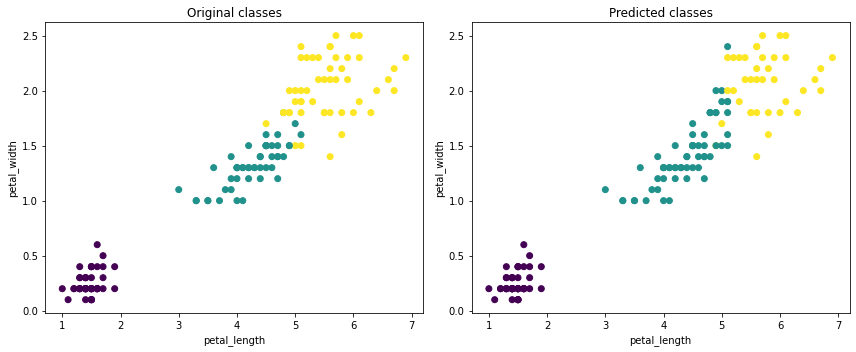

In [14]:
fig = plt.figure(figsize=(12, 5))

plt.subplot(121)
df_trans.scatter(df_trans.petal_length, df_trans.petal_width, c_expr=df_trans.class_)
plt.title('Original classes')

plt.subplot(122)
df_trans.scatter(df_trans.petal_length, df_trans.petal_width, c_expr=df_trans.predicted_kmean_map)
plt.title('Predicted classes')

plt.tight_layout()
plt.show()

As with any algorithm implemented in `vaex.ml`, K-Means can be used on billions of samples. Fitting takes **under 2 minutes** when applied on the oversampled Iris dataset, numbering over **1 billion** samples.

In [15]:
df = vaex.ml.datasets.load_iris_1e9()
n_samples = len(df)
print(f'Number of samples in DataFrame: {n_samples:,}')

Number of samples in DataFrame: 1,005,000,000


In [16]:
%%time

features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
kmeans = vaex.ml.cluster.KMeans(features=features, n_clusters=3, max_iter=100, verbose=True, random_state=31)
kmeans.fit(df)

Iteration    0, inertia  1272768079.8016784
Iteration    1, inertia  818533259.4873675
Iteration    2, inertia  813586111.1870002
Iteration    3, inertia  812725317.4234301
Iteration    4, inertia  812680582.0575261
Iteration    5, inertia  812680582.057527
CPU times: user 2min 46s, sys: 1.14 s, total: 2min 48s
Wall time: 21.2 s


## Supervised learning

While `vaex.ml` does not yet implement any supervised machine learning models, it does provide wrappers to several popular libraries such as [scikit-learn](https://scikit-learn.org/), [XGBoost](https://xgboost.readthedocs.io/), [LightGBM](https://lightgbm.readthedocs.io/) and [CatBoost](https://catboost.ai/). 

The main benefit of these wrappers is that they turn the models into `vaex.ml` transformers. This means the models become part of the DataFrame _state_ and thus can be serialized, and their predictions can be returned as _virtual columns_. This is especially useful for creating various diagnostic plots and evaluating performance metrics at no memory cost, as well as building ensembles. 

### `Scikit-Learn` example

The `vaex.ml.sklearn` module provides convenient wrappers to the `scikit-learn` estimators. In fact, these wrappers can be used with any library that follows the API convention established by `scikit-learn`, i.e. implements the `.fit` and `.transform` methods.

Here is an example:

In [17]:
from vaex.ml.sklearn import Predictor
from sklearn.ensemble import GradientBoostingClassifier

df = vaex.ml.datasets.load_iris()

features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
target = 'class_'

model = GradientBoostingClassifier(random_state=42)
vaex_model = Predictor(features=features, target=target, model=model, prediction_name='prediction')

vaex_model.fit(df=df)

df = vaex_model.transform(df)
df

#,sepal_length,sepal_width,petal_length,petal_width,class_,prediction
0,5.9,3.0,4.2,1.5,1,1
1,6.1,3.0,4.6,1.4,1,1
2,6.6,2.9,4.6,1.3,1,1
3,6.7,3.3,5.7,2.1,2,2
4,5.5,4.2,1.4,0.2,0,0
...,...,...,...,...,...,...
145,5.2,3.4,1.4,0.2,0,0
146,5.1,3.8,1.6,0.2,0,0
147,5.8,2.6,4.0,1.2,1,1
148,5.7,3.8,1.7,0.3,0,0


One can still train a predictive model on datasets that are too big to fit into memory by leveraging the on-line learners provided by `scikit-learn`. The `vaex.ml.sklearn.IncrementalPredictor` conveniently wraps these learners and provides control on how the data is passed to them from a `vaex` DataFrame. 

Let us train a model on the oversampled Iris dataset which comprises over 1 billion samples.

In [18]:
from vaex.ml.sklearn import IncrementalPredictor
from sklearn.linear_model import SGDClassifier

df = vaex.ml.datasets.load_iris_1e9()

features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
target = 'class_'

model = SGDClassifier(learning_rate='constant', eta0=0.0001, random_state=42)
vaex_model = IncrementalPredictor(features=features, target=target, model=model, 
                                  batch_size=11_000_000, partial_fit_kwargs={'classes':[0, 1, 2]})

vaex_model.fit(df=df, progress='widget')

df = vaex_model.transform(df)
df

#,sepal_length,sepal_width,petal_length,petal_width,class_,prediction
0,5.9,3.0,4.2,1.5,0,0
1,6.1,3.0,4.6,1.4,0,0
2,6.6,2.9,4.6,1.3,0,0
3,6.7,3.3,5.7,2.1,0,0
4,5.5,4.2,1.4,0.2,0,0
...,...,...,...,...,...,...
"1,004,999,995",5.2,3.4,1.4,0.0,0,0
"1,004,999,996",5.1,3.8,1.6,0.0,0,0
"1,004,999,997",5.8,2.6,4.0,0.0,0,0
"1,004,999,998",5.7,3.8,1.7,0.0,0,0


### `XGBoost` example

Libraries such as `XGBoost` provide more options such as validation during training and early stopping for example. We provide wrappers that keeps close to the native API of these libraries, in addition to the `scikit-learn` API. 

While the following example showcases the `XGBoost` wrapper, `vaex.ml` implements similar wrappers for `LightGBM` and `CatBoost`.

In [19]:
from vaex.ml.xgboost import XGBoostModel

df = vaex.ml.datasets.load_iris_1e5()
df_train, df_test = df.ml.train_test_split(test_size=0.2, verbose=False)

features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
target = 'class_'

params = {'learning_rate': 0.1,
          'max_depth': 3, 
          'num_class': 3, 
          'objective': 'multi:softmax',
          'subsample': 1,
          'random_state': 42,
          'n_jobs': -1}


booster = XGBoostModel(features=features, target=target, num_boost_round=500, params=params)
booster.fit(df=df_train, evals=[(df_train, 'train'), (df_test, 'test')], early_stopping_rounds=5)

df_test = booster.transform(df_train)
df_test

#,sepal_length,sepal_width,petal_length,petal_width,class_,xgboost_prediction
0,5.9,3.0,4.2,1.5,1,1.0
1,6.1,3.0,4.6,1.4,1,1.0
2,6.6,2.9,4.6,1.3,1,1.0
3,6.7,3.3,5.7,2.1,2,2.0
4,5.5,4.2,1.4,0.2,0,0.0
...,...,...,...,...,...,...
"80,395",5.2,3.4,1.4,0.2,0,0.0
"80,396",5.1,3.8,1.6,0.2,0,0.0
"80,397",5.8,2.6,4.0,1.2,1,1.0
"80,398",5.7,3.8,1.7,0.3,0,0.0


### `CatBoost` example

The CatBoost library supports summing up models. With this feature, we can use CatBoost to train a model using data that is otherwise too large to fit in memory. The idea is to train a single CatBoost model per chunk of data, and than sum up the invidiual models to create a master model. To use this feature via `vaex.ml` just specify the `batch_size` argument in the `CatBoostModel` wrapper. One can also specify additional options such as the strategy on how to sum up the individual models, or how they should be weighted.

In [20]:
from vaex.ml.catboost import CatBoostModel

df = vaex.ml.datasets.load_iris_1e8()
df_train, df_test = df.ml.train_test_split(test_size=0.2, verbose=False)

features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
target = 'class_'

params = {
    'leaf_estimation_method': 'Gradient',
    'learning_rate': 0.1,
    'max_depth': 3,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8,
    'sampling_frequency': 'PerTree',
    'colsample_bylevel': 0.8,
    'reg_lambda': 1,
    'objective': 'MultiClass',
    'eval_metric': 'MultiClass',
    'random_state': 42,
    'verbose': 0,
}

booster = CatBoostModel(features=features, target=target, num_boost_round=23, 
                        params=params, prediction_type='Class', batch_size=11_000_000)
booster.fit(df=df_train, progress='widget')

df_test = booster.transform(df_train)
df_test

#,sepal_length,sepal_width,petal_length,petal_width,class_,catboost_prediction
0,5.9,3.0,4.2,1.5,1,[1]
1,6.1,3.0,4.6,1.4,1,[1]
2,6.6,2.9,4.6,1.3,1,[1]
3,6.7,3.3,5.7,2.1,2,[2]
4,5.5,4.2,1.4,0.2,0,[0]
...,...,...,...,...,...,...
"80,399,995",5.2,3.4,1.4,0.2,0,[0]
"80,399,996",5.1,3.8,1.6,0.2,0,[0]
"80,399,997",5.8,2.6,4.0,1.2,1,[1]
"80,399,998",5.7,3.8,1.7,0.3,0,[0]


## State transfer - pipelines made easy

Each `vaex` DataFrame consists of two parts: _data_ and _state_. The _data_ is immutable, and any operation such as filtering, adding new columns, or applying transformers or predictive models just modifies the _state_. This is extremely powerful concept and can completely redefine how we imagine machine learning pipelines. 

As an example, let us once again create a model based on the Iris dataset. Here, we will create a couple of new features, do a PCA transformation, and finally train a predictive model. 

In [21]:
# Load data and split it in train and test sets
df = vaex.ml.datasets.load_iris()
df_train, df_test = df.ml.train_test_split(test_size=0.2, verbose=False)

# Create new features
df_train['petal_ratio'] = df_train.petal_length / df_train.petal_width
df_train['sepal_ratio'] = df_train.sepal_length / df_train.sepal_width

# Do a PCA transformation
features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width', 'petal_ratio', 'sepal_ratio']
pca = vaex.ml.PCA(features=features, n_components=6)
df_train = pca.fit_transform(df_train)

# Display the training DataFrame at this stage
df_train

#,sepal_length,sepal_width,petal_length,petal_width,class_,petal_ratio,sepal_ratio,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,5.4,3.0,4.5,1.5,1,3.0,1.8,-1.510547480171215,0.3611524321126822,-0.4005106138591812,0.5491844107628985,0.21135370342329635,-0.009542243224854377
1,4.8,3.4,1.6,0.2,0,8.0,1.411764705882353,4.447550641536847,0.2799644730487585,-0.04904458661276928,0.18719360579644695,0.10928493945448532,0.005228919010020094
2,6.9,3.1,4.9,1.5,1,3.266666666666667,2.2258064516129035,-1.777649528149752,-0.6082889770845891,0.48007833550651513,-0.37762011866831335,0.05174472701894024,-0.04673816474220924
3,4.4,3.2,1.3,0.2,0,6.5,1.375,3.400548263702555,1.437036928591846,-0.3662652846960042,0.23420836198441913,0.05750021481634099,-0.023055011653267066
4,5.6,2.8,4.9,2.0,2,2.45,2.0,-2.3245098766222094,0.14710673877401348,-0.5150809942258257,0.5471824391426298,-0.12154714382375817,0.0044686197532133876
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,5.2,3.4,1.4,0.2,0,6.999999999999999,1.5294117647058825,3.623794583238953,0.8255759252729563,0.23453320686724874,-0.17599408825208826,-0.04687036865354327,-0.02424621891240747
116,5.1,3.8,1.6,0.2,0,8.0,1.3421052631578947,4.42115266246093,0.22287505533663704,0.4450642830179705,0.2184424557783562,0.14504752606375293,0.07229123907677276
117,5.8,2.6,4.0,1.2,1,3.3333333333333335,2.230769230769231,-1.069062832993727,0.3874258314654399,-0.4471767749236783,-0.2956609879568117,-0.0010695982441835394,-0.0065225306610744715
118,5.7,3.8,1.7,0.3,0,5.666666666666667,1.5000000000000002,2.2846521048417037,1.1920826609681359,0.8273738848637026,-0.21048946462725737,0.03381892388998425,0.018792165273013528


At this point, we are ready to train a predictive model. In this example, let's use `LightGBM` with its `scikit-learn` API. 

In [22]:
import lightgbm

features = df_train.get_column_names(regex='^PCA')

booster = lightgbm.LGBMClassifier()

vaex_model = Predictor(model=booster, features=features, target='class_')

vaex_model.fit(df=df_train)
df_train = vaex_model.transform(df_train)

df_train

#,sepal_length,sepal_width,petal_length,petal_width,class_,petal_ratio,sepal_ratio,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,prediction
0,5.4,3.0,4.5,1.5,1,3.0,1.8,-1.510547480171215,0.3611524321126822,-0.4005106138591812,0.5491844107628985,0.21135370342329635,-0.009542243224854377,1
1,4.8,3.4,1.6,0.2,0,8.0,1.411764705882353,4.447550641536847,0.2799644730487585,-0.04904458661276928,0.18719360579644695,0.10928493945448532,0.005228919010020094,0
2,6.9,3.1,4.9,1.5,1,3.266666666666667,2.2258064516129035,-1.777649528149752,-0.6082889770845891,0.48007833550651513,-0.37762011866831335,0.05174472701894024,-0.04673816474220924,1
3,4.4,3.2,1.3,0.2,0,6.5,1.375,3.400548263702555,1.437036928591846,-0.3662652846960042,0.23420836198441913,0.05750021481634099,-0.023055011653267066,0
4,5.6,2.8,4.9,2.0,2,2.45,2.0,-2.3245098766222094,0.14710673877401348,-0.5150809942258257,0.5471824391426298,-0.12154714382375817,0.0044686197532133876,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,5.2,3.4,1.4,0.2,0,6.999999999999999,1.5294117647058825,3.623794583238953,0.8255759252729563,0.23453320686724874,-0.17599408825208826,-0.04687036865354327,-0.02424621891240747,0
116,5.1,3.8,1.6,0.2,0,8.0,1.3421052631578947,4.42115266246093,0.22287505533663704,0.4450642830179705,0.2184424557783562,0.14504752606375293,0.07229123907677276,0
117,5.8,2.6,4.0,1.2,1,3.3333333333333335,2.230769230769231,-1.069062832993727,0.3874258314654399,-0.4471767749236783,-0.2956609879568117,-0.0010695982441835394,-0.0065225306610744715,1
118,5.7,3.8,1.7,0.3,0,5.666666666666667,1.5000000000000002,2.2846521048417037,1.1920826609681359,0.8273738848637026,-0.21048946462725737,0.03381892388998425,0.018792165273013528,0


The final `df_train` DataFrame contains all the features we created, including the predictions right at the end. Now, we would like to apply the same transformations to the test set. All we need to do, is to simply extract the _state_ from `df_train` and apply it to `df_test`. This will propagate all the changes that were made to the training set on the test set.


In [23]:
state = df_train.state_get()

df_test.state_set(state)
df_test

#,sepal_length,sepal_width,petal_length,petal_width,class_,petal_ratio,sepal_ratio,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,prediction
0,5.9,3.0,4.2,1.5,1,2.8000000000000003,1.9666666666666668,-1.642627940409072,0.49931302910747727,-0.06308800806664466,0.10842057110641677,-0.03924298664189224,-0.027394439700272822,1
1,6.1,3.0,4.6,1.4,1,3.2857142857142856,2.033333333333333,-1.445047446393471,-0.1019091578746504,-0.01899012239493801,0.020980767646090408,0.1614215276667148,-0.02716639637934938,1
2,6.6,2.9,4.6,1.3,1,3.538461538461538,2.2758620689655173,-1.330564613235537,-0.41978474749131267,0.1759590589290671,-0.4631301992308477,0.08304243689815374,-0.033351733677429274,1
3,6.7,3.3,5.7,2.1,2,2.7142857142857144,2.0303030303030303,-2.6719170661531013,-0.9149428897499291,0.4156162725009377,0.34633692661436644,0.03742964707590906,-0.013254286196245774,2
4,5.5,4.2,1.4,0.2,0,6.999999999999999,1.3095238095238095,3.6322930267831404,0.8198526437905096,1.046277579362938,0.09738737839850209,0.09412658096734221,0.1329137026697501,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,5.5,2.5,4.0,1.3,1,3.0769230769230766,2.2,-1.2523120088600896,0.5975071562677784,-0.7019801415469216,-0.11489031841855571,-0.03615945782087869,0.005496321827264977,1
26,5.8,2.7,3.9,1.2,1,3.25,2.148148148148148,-1.0792352165904657,0.5236883751378523,-0.34037717939532286,-0.23743695029955128,-0.00936891422024664,-0.02184110533380834,1
27,4.4,2.9,1.4,0.2,0,6.999999999999999,1.517241379310345,3.7422969192506095,1.048460304741977,-0.636475521315278,0.07623157913054074,0.004215355833312173,-0.06354157393133958,0
28,4.5,2.3,1.3,0.3,0,4.333333333333334,1.956521739130435,1.4537380535696471,2.4197864889383505,-1.0301500321688102,-0.5150263062576134,-0.2631218962099228,-0.06608059456656257,0


And just like that `df_test` contains all the columns, transformations and the prediction we modelled on the training set. The state can be easily serialized to disk in a form of a JSON file. This makes deployment of a machine learning model as trivial as simply copying a JSON file from one environment to another.

In [24]:
df_train.state_write('./iris_model.json')

df_test.state_load('./iris_model.json')
df_test

#,sepal_length,sepal_width,petal_length,petal_width,class_,petal_ratio,sepal_ratio,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,prediction
0,5.9,3.0,4.2,1.5,1,2.8000000000000003,1.9666666666666668,-1.642627940409072,0.49931302910747727,-0.06308800806664466,0.10842057110641677,-0.03924298664189224,-0.027394439700272822,1
1,6.1,3.0,4.6,1.4,1,3.2857142857142856,2.033333333333333,-1.445047446393471,-0.1019091578746504,-0.01899012239493801,0.020980767646090408,0.1614215276667148,-0.02716639637934938,1
2,6.6,2.9,4.6,1.3,1,3.538461538461538,2.2758620689655173,-1.330564613235537,-0.41978474749131267,0.1759590589290671,-0.4631301992308477,0.08304243689815374,-0.033351733677429274,1
3,6.7,3.3,5.7,2.1,2,2.7142857142857144,2.0303030303030303,-2.6719170661531013,-0.9149428897499291,0.4156162725009377,0.34633692661436644,0.03742964707590906,-0.013254286196245774,2
4,5.5,4.2,1.4,0.2,0,6.999999999999999,1.3095238095238095,3.6322930267831404,0.8198526437905096,1.046277579362938,0.09738737839850209,0.09412658096734221,0.1329137026697501,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,5.5,2.5,4.0,1.3,1,3.0769230769230766,2.2,-1.2523120088600896,0.5975071562677784,-0.7019801415469216,-0.11489031841855571,-0.03615945782087869,0.005496321827264977,1
26,5.8,2.7,3.9,1.2,1,3.25,2.148148148148148,-1.0792352165904657,0.5236883751378523,-0.34037717939532286,-0.23743695029955128,-0.00936891422024664,-0.02184110533380834,1
27,4.4,2.9,1.4,0.2,0,6.999999999999999,1.517241379310345,3.7422969192506095,1.048460304741977,-0.636475521315278,0.07623157913054074,0.004215355833312173,-0.06354157393133958,0
28,4.5,2.3,1.3,0.3,0,4.333333333333334,1.956521739130435,1.4537380535696471,2.4197864889383505,-1.0301500321688102,-0.5150263062576134,-0.2631218962099228,-0.06608059456656257,0
